# DLAV Project - Phase 3

The first step is to prepare the data. The code below will download the data from google drive and extract it here for your code to use.

In [2]:
# Install gdown to handle Google Drive file download
import gdown
import zipfile
import os

def folder_exists_and_not_empty(folder):
    return os.path.isdir(folder) and len(os.listdir(folder)) > 0

datasets = {
    "train": ("https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr", "phase3_dlav_train.zip"),
    "val_real": ("https://drive.google.com/uc?id=17DREGym_-v23f_qbkMHr7vJstbuTt0if", "phase3_dlav_val.zip"),
    "test_real_public" : ("https://drive.google.com/uc?id=1_l6cui0pCJ_caixN0uTkkUOfu6ICO8u5", "phase3_dlav_test_public.zip"),
}


for folder, (url, zip_name) in datasets.items():
    if not folder_exists_and_not_empty("phase3/"+folder):
        print(f"Downloading and extracting {folder} dataset...")
        gdown.download(url, zip_name, quiet=False)

        # Define the target extraction directory
        os.makedirs("phase3", exist_ok=True)  # Ensure the directory exists

        with zipfile.ZipFile(zip_name, 'r') as zip_ref:
            zip_ref.extractall("phase3")  # Extract into the specified directory

        os.remove(zip_name)
    else:
        print(f"{folder} folder already exists and is not empty. Skipping download.")




train folder already exists and is not empty. Skipping download.
val_real folder already exists and is not empty. Skipping download.


Downloading...
From (original): https://drive.google.com/uc?id=1_l6cui0pCJ_caixN0uTkkUOfu6ICO8u5
From (redirected): https://drive.google.com/uc?id=1_l6cui0pCJ_caixN0uTkkUOfu6ICO8u5&confirm=t&uuid=e228eb27-fecd-42d6-adcf-23262e66b754
To: c:\Users\mathe\Documents\Scolaire\DLFAV\Project\phase3_dlav_test_public.zip
100%|██████████| 110M/110M [00:03<00:00, 31.3MB/s] 


Now lets load the data and visualize the first few examples to see what we are dealing with!

8
8
8
8


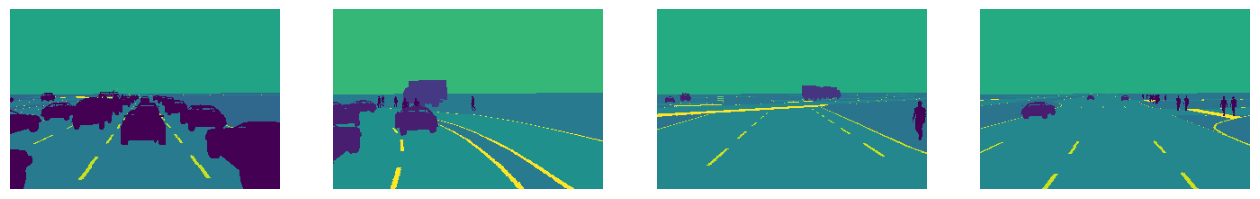

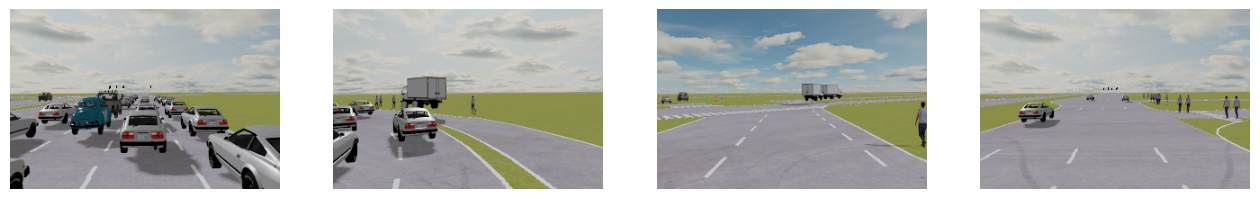

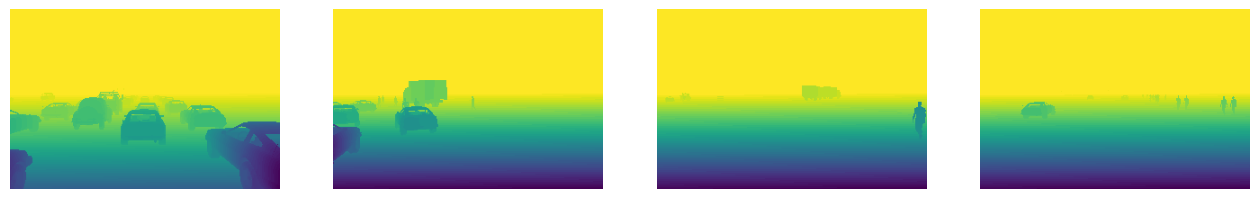

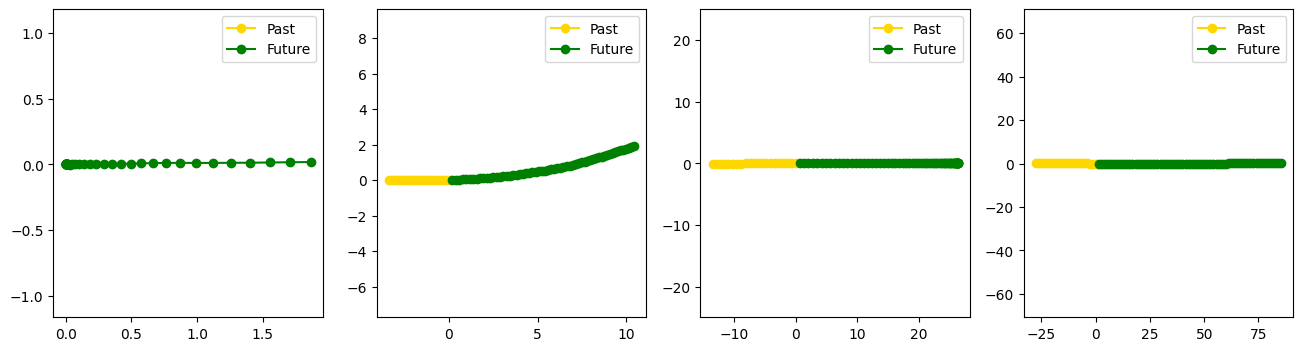

driving_command: forward
driving_command: forward
driving_command: forward
driving_command: forward


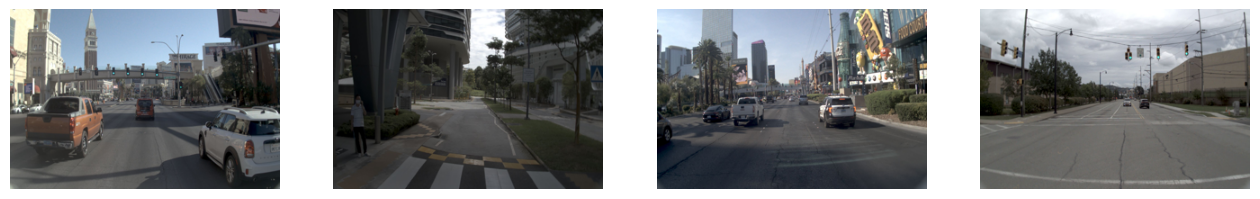

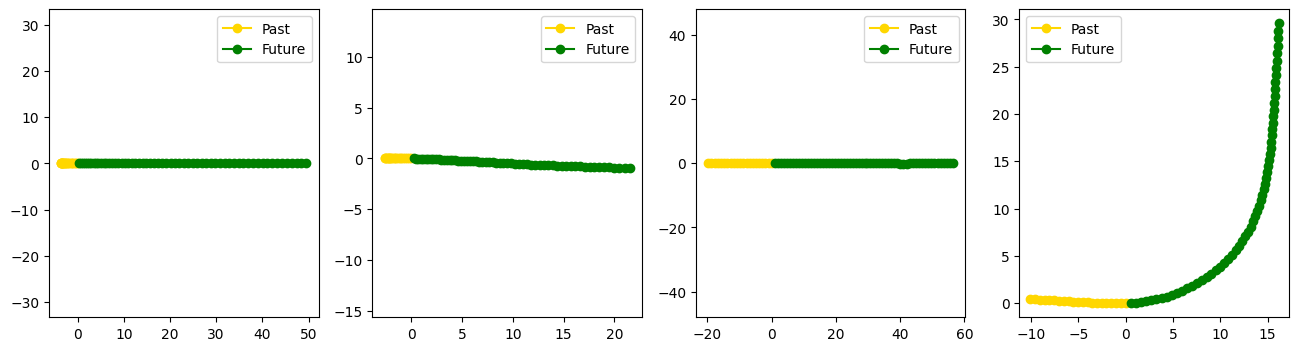

In [3]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random

k = 4
# load the data
data = []
for i in random.choices(np.arange(1000), k=k):
    with open(f"phase3/train/{i}.pkl", "rb") as f:
        data.append(pickle.load(f))
# plot the camera view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    print(data[i]["semantic_label"][0][0])
    axis[i].imshow(data[i]["semantic_label"])
    axis[i].axis("off")
plt.show()

# plot the camera view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].imshow(data[i]["camera"])
    axis[i].axis("off")
plt.show()

# plot the camera view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].imshow(data[i]["depth"])
    axis[i].axis("off")
plt.show()

# plot the past and future trajectory of the vehicle
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].plot(data[i]["sdc_history_feature"][:, 0], data[i]["sdc_history_feature"][:, 1], "o-", color="gold", label="Past")
    axis[i].plot(data[i]["sdc_future_feature"][:, 0], data[i]["sdc_future_feature"][:, 1], "o-", color="green", label="Future")
    axis[i].legend()
    axis[i].axis("equal")
plt.show()

for i in range(k):
    print(f"driving_command: {data[i]['driving_command']}")


k = 4
# load the data
data = []
test_files = os.listdir("phase3/val_real")

for i in range(k):
    with open(f"phase3/val_real/{test_files[i]}", "rb") as f:
        data.append(pickle.load(f))

# plot the camera view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].imshow(data[i]["camera"])
    axis[i].axis("off")
plt.show()

# plot the past and future trajectory of the vehicle
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].plot(data[i]["sdc_history_feature"][:, 0], data[i]["sdc_history_feature"][:, 1], "o-", color="gold", label="Past")
    axis[i].plot(data[i]["sdc_future_feature"][:, 0], data[i]["sdc_future_feature"][:, 1], "o-", color="green", label="Future")
    axis[i].legend()
    axis[i].axis("equal")
plt.show()

Now its time to make our hands dirty!

In the following cells we will define the classes we need to do a proper training in pytorch.

1. We will start with defining a Dataset class which loads the data and does some basic preprocessing. You can further process this data as you see fit.
2. We then define the logger which receives training metrics and logs and prints/visualizes them. Having a good logger means a lot when dealing with neural network training! The logger implemented here is very simple and we strongly suggest you try other ways of visualizing your losses and metrics. Be creative ;)
3. We then proceed with defining the core part of the pipeline, the model. You are going to mainly implement the model yourself, but we have provided a very simple model so that the code runs as is so that you can see how the whole framework runs all in all.
4. Finally, we define the training funciton which contains the training loop, and we call it to see the magic! You'll need to also do a lot of changes here, from the batch size and learning rate, to adding augmentation schemes and schedulers, etc.

In [4]:
import torch
import os
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


CUDA available: True
GPU name: NVIDIA GeForce RTX 4060 Ti


In [5]:
import os
import torch
import pickle
import numpy as np
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import cv2
import random
from torch.utils.data import Dataset

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

class DrivingDataset(Dataset):
    def __init__(self, file_list, test=False):
        self.samples = file_list
        self.test = test


    def __len__(self):
        return len(self.samples)


    def __getitem__(self, idx):
        with open(self.samples[idx], 'rb') as f:
            data = pickle.load(f)

        camera = torch.FloatTensor(data['camera']).permute(2, 0, 1) / 255.0
        history = torch.FloatTensor(data['sdc_history_feature'])


        if not self.test:
            future = torch.FloatTensor(data['sdc_future_feature'])
            return {
                'camera': camera,
                'history': history,
                'future': future
            }

        else:
            return {
                'camera': camera,
                'history': history
            }


In [6]:
import matplotlib.pyplot as plt

class Logger:
    def __init__(self):
        # will hold per-epoch losses
        self.history = {'train_loss': [], 'val_loss': []}

    def log_epoch(self, epoch, train_loss, val_loss, **metrics):
        """
        Call once per epoch.
        """
        # store
        self.history['train_loss'].append(train_loss)
        self.history['val_loss'].append(val_loss)

    def plot(self):
        """
        Call after training to visualize the curves.
        """
        epochs = range(1, len(self.history['train_loss'])+1)
        plt.figure(figsize=(6,4))
        plt.plot(epochs, self.history['train_loss'], label='Train Loss')
        plt.plot(epochs, self.history['val_loss'],   label='Val   Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss vs. Epoch')
        plt.legend()
        plt.tight_layout()
        plt.show()


In [7]:
import torch
import torch.nn as nn

class TrajGRU(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=128, num_layers=1):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
    
    def forward(self, x): 
        _, h_n = self.gru(x)  
        return h_n[-1]  


In [8]:
import torch
import torch.nn as nn

class SlimConvNet(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),  
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2), 

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4))  
        )

        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

    def forward(self, x):
        x = self.features(x)         
        spatial_features = x        
        flat = self.flatten(x)       
        flat = self.fc(flat)           
        return flat, spatial_features              


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SemanticDecoder(nn.Module):
    def __init__(self, num_classes=14):
        super().__init__()

        self.up1 = self.up_block(128, 64)   
        self.up2 = self.up_block(64, 64)    
        self.up3 = self.up_block(64, 32)   
        self.up4 = self.up_block(32, 16)   
        self.up5 = self.up_block(16, 8)    
        
        self.out_conv = nn.Conv2d(8, num_classes, kernel_size=1)  

    def up_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2,
                               padding=1, output_padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.up1(x)   
        x = self.up2(x)   
        x = self.up3(x)   
        x = self.up4(x)   
        x = self.up5(x)   

        x = F.interpolate(x, size=(224, 320), mode='bilinear', align_corners=False)
        return self.out_conv(x) 


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DepthDecoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.up1 = self.up_block(128, 64)   
        self.up2 = self.up_block(64, 64)   
        self.up3 = self.up_block(64, 32)    
        self.up4 = self.up_block(32, 16)   
        self.up5 = self.up_block(16, 8)    

        self.out_conv = nn.Conv2d(8, 1, kernel_size=1)

    def up_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.up1(x)  
        x = self.up2(x)  
        x = self.up3(x)  
        x = self.up4(x)   
        x = self.up5(x)   

        x = F.interpolate(x, size=(224, 320), mode='bilinear', align_corners=False)
        x = self.out_conv(x)  
        return x


In [11]:
class DrivingPlanner(nn.Module):
    def __init__(self,num_channels=3, history_dim=128, use_aux = True):
        super().__init__()

        self.cnn = SlimConvNet(in_channels=num_channels)

        self.rnn_history = TrajGRU(input_dim=3, hidden_dim=history_dim)

        cnn_embed_dim = 512
        history_feature_dim = history_dim

        decoder_input_dim = cnn_embed_dim + history_feature_dim

        self.decoder = nn.Sequential(
            nn.Linear(decoder_input_dim, 256),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(256, 60*3)
        )

        self.residual = nn.Linear(decoder_input_dim, 60*3)
        self.use_aux = use_aux
        if self.use_aux:
        
            self.semantic_decoder = SemanticDecoder()
            self.depth_decoder = DepthDecoder()

    def forward(self, camera, history):

        orig_h, orig_w = camera.shape[2], camera.shape[3]

        pad_h = 224 - orig_h
        pad_w = 320 - orig_w
        camera = F.pad(camera, (0, pad_w, 0, pad_h), mode='replicate')
        
        visual_features_flat, visual_features_spatial = self.cnn(camera)  

        history_features = self.rnn_history(history)

        combined_features = torch.cat([visual_features_flat, history_features], dim=1)

        x = self.decoder(combined_features)
        x = self.residual(combined_features) + x
        x = x.reshape(-1, 60, 3) 

        if self.use_aux:
            pred_depth = self.depth_decoder(visual_features_spatial)    
            pred_semantic = self.semantic_decoder(visual_features_spatial)
            pred_depth = pred_depth[:, :, :orig_h, :orig_w]
            pred_semantic = pred_semantic[:, :, :orig_h, :orig_w]

            return x, pred_depth.permute(0, 2, 3, 1), pred_semantic  
        else:
            return x, None, None  


In [12]:
import torch
import torch.nn.functional as F
import tqdm

criterion = nn.SmoothL1Loss()
def train_one_epoch(model, train_loader, optimizer, device, lambda_depth=0.1, lambda_sem=0.1, use_aux=False, pbar=None):
    model.train()
    train_loss = 0.0
    if use_aux:
        depth_loss_tot = 0.0
        sem_loss_tot = 0.0
        traj_loss_tot = 0.0
    for idx, batch in enumerate(pbar):
        if use_aux : 
            cam, hist, fut, dep, sem = [batch[k].to(device) for k in ['camera', 'history', 'future', 'depth', 'semantic']]
        else:
            cam, hist, fut = [batch[k].to(device) for k in ['camera', 'history', 'future']]
        optimizer.zero_grad()
        fut_pred, dep_pred, sem_pred = model(cam, hist)

        traj_loss = criterion(fut_pred, fut)
        loss = traj_loss
        if use_aux:
            traj_loss_tot += traj_loss.item()
            depth_loss = lambda_depth * F.smooth_l1_loss(dep_pred, dep)
            depth_loss_tot += depth_loss.item()
            loss += depth_loss
            sem_loss = lambda_sem * F.cross_entropy(sem_pred, sem.long())
            sem_loss_tot += sem_loss.item()
            loss += sem_loss

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader)
    if use_aux:
        avg_depth_loss = depth_loss_tot / len(train_loader)
        avg_sem_loss = sem_loss_tot / len(train_loader)
        avg_traj_loss = traj_loss_tot / len(train_loader)
        return avg_loss, avg_traj_loss, avg_depth_loss, avg_sem_loss
    else:
        return avg_loss, 0, 0, 0

def validate(model, val_loader, device):
    model.eval()
    ade_all = []
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            camera = batch['camera'].to(device)
            history = batch['history'].to(device)
            future = batch['future'].to(device)

            pred_future, pred_depth, pred_sem = model(camera, history)
            ADE = torch.norm(pred_future[:, :, :2] - future[:, :, :2], p=2, dim=-1).mean()
            ade_all.append(ADE.item())
            

            traj_loss = criterion(pred_future, future)
            loss = traj_loss
            val_loss += loss.item()

    avg_val = val_loss   / len(val_loader)
    ade_avg = sum(ade_all) / len(ade_all)
    return avg_val, ade_avg


def train(model, train_loader, val_loader, optimizer,scheduler, logger, num_epochs=50, lambda_depth=0.1, lambda_sem=0.1, use_aux=False, patience=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model = model.to(device)
    best_ade = float('inf')
    average_ade = 0
    ades = []
    epochs_without_improvement = 0
    GREEN = "\033[92m"
    RED = "\033[91m"

    for epoch in range(num_epochs):
        pbar = tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False, colour='magenta')

        train_loss, traj_loss, depth_loss, sem_loss = train_one_epoch(model, train_loader, optimizer, device, lambda_depth,lambda_sem, use_aux, pbar)
        val_loss, ade = validate(model, val_loader, device)
        ades.append(ade)
        if len(ades)>10:
            ades.pop(0)
        
        average_ade = np.array(ades).mean()

        color = GREEN if average_ade<best_ade else RED

        print(f"{color}Epoch {epoch+1} - [ADE : {ade:.4f}] - [avg ADE : {average_ade:.4f}]")
        print(f"Train - Loss: {train_loss:.4f}, Traj_loss {traj_loss:.4f}, depth_loss {depth_loss:.4f}, sem_loss {sem_loss:.4f}")
        print(f"Validation - Loss: {val_loss:.4f}")
        scheduler.step(val_loss)
        logger.log_epoch(epoch, train_loss, val_loss)

        if average_ade < best_ade:
            best_ade = average_ade
            epochs_without_improvement = 0
            best_model_state = model.state_dict() 
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                model.load_state_dict(best_model_state)  
                break


In [13]:
import torch.optim as optim
from torch.utils.data import DataLoader
import os
from torch.optim.lr_scheduler import ReduceLROnPlateau

train_data_dir = "phase3/val_real"

train_files = [os.path.join(train_data_dir, f) for f in os.listdir(train_data_dir) if f.endswith('.pkl')]
val_files = [train_files[i] for i in range(800, 1000)]
train_files = [train_files[i] for i in range(800)]

train_dataset = DrivingDataset(train_files)
val_dataset = DrivingDataset(val_files)

train_loader = DataLoader(train_dataset, batch_size=32, num_workers=0, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=0, pin_memory=True)

model = DrivingPlanner()
state_dict = torch.load('phase2_model.pth', map_location='cuda')
model.load_state_dict(state_dict)
model.to('cuda')

optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)

logger = Logger()

train(model, train_loader, val_loader, optimizer, scheduler, logger, num_epochs=100, lambda_depth=0.001, lambda_sem=0.4, use_aux=False)




Using device: cuda


Epoch 1 - [ADE : 1.9135] - [avg ADE : 1.9135]
Train - Loss: 0.6603, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.6113


Epoch 2 - [ADE : 1.8642] - [avg ADE : 1.8889]
Train - Loss: 0.5688, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5890


Epoch 3 - [ADE : 1.8721] - [avg ADE : 1.8833]
Train - Loss: 0.5563, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5882


Epoch 4 - [ADE : 1.8542] - [avg ADE : 1.8760]
Train - Loss: 0.5606, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5830


Epoch 5 - [ADE : 1.8223] - [avg ADE : 1.8653]
Train - Loss: 0.5466, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5734


Epoch 6 - [ADE : 1.8218] - [avg ADE : 1.8580]
Train - Loss: 0.5286, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5715


Epoch 7 - [ADE : 1.8466] - [avg ADE : 1.8564]
Train - Loss: 0.5128, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5787


Epoch 8 - [ADE : 1.8339] - [avg ADE : 1.8536]
Train - Loss: 0.5102, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5766


Epoch 9 - [ADE : 1.8632] - [avg ADE : 1.8546]
Train - Loss: 0.5072, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5850


Epoch 10 - [ADE : 1.8513] - [avg ADE : 1.8543]
Train - Loss: 0.5233, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5799


Epoch 11 - [ADE : 1.8310] - [avg ADE : 1.8461]
Train - Loss: 0.4812, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5761


Epoch 12 - [ADE : 1.8221] - [avg ADE : 1.8418]
Train - Loss: 0.4851, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5731


Epoch 13 - [ADE : 1.8114] - [avg ADE : 1.8358]
Train - Loss: 0.4758, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5691


Epoch 14 - [ADE : 1.8071] - [avg ADE : 1.8311]
Train - Loss: 0.4747, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5674


Epoch 15 - [ADE : 1.8204] - [avg ADE : 1.8309]
Train - Loss: 0.4846, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5724


Epoch 16 - [ADE : 1.8210] - [avg ADE : 1.8308]
Train - Loss: 0.4683, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5729


Epoch 17 - [ADE : 1.8118] - [avg ADE : 1.8273]
Train - Loss: 0.4878, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5696


Epoch 18 - [ADE : 1.8073] - [avg ADE : 1.8247]
Train - Loss: 0.4775, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5675


Epoch 19 - [ADE : 1.8057] - [avg ADE : 1.8189]
Train - Loss: 0.4757, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5672


Epoch 20 - [ADE : 1.8095] - [avg ADE : 1.8147]
Train - Loss: 0.4743, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5686


Epoch 21 - [ADE : 1.8072] - [avg ADE : 1.8123]
Train - Loss: 0.4768, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5682


Epoch 22 - [ADE : 1.8062] - [avg ADE : 1.8108]
Train - Loss: 0.4720, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5678


Epoch 23 - [ADE : 1.8068] - [avg ADE : 1.8103]
Train - Loss: 0.4759, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5680


Epoch 24 - [ADE : 1.8074] - [avg ADE : 1.8103]
Train - Loss: 0.4712, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5679


Epoch 25 - [ADE : 1.8071] - [avg ADE : 1.8090]
Train - Loss: 0.4678, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5680


Epoch 26 - [ADE : 1.8068] - [avg ADE : 1.8076]
Train - Loss: 0.4684, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5678


Epoch 27 - [ADE : 1.8056] - [avg ADE : 1.8070]
Train - Loss: 0.4572, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5677


Epoch 28 - [ADE : 1.8053] - [avg ADE : 1.8068]
Train - Loss: 0.4726, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5672


Epoch 29 - [ADE : 1.8056] - [avg ADE : 1.8068]
Train - Loss: 0.4719, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5675


Epoch 30 - [ADE : 1.8067] - [avg ADE : 1.8065]
Train - Loss: 0.4702, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5680


Epoch 31 - [ADE : 1.8065] - [avg ADE : 1.8064]
Train - Loss: 0.4795, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5679


Epoch 32 - [ADE : 1.8061] - [avg ADE : 1.8064]
Train - Loss: 0.4747, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5677


Epoch 33 - [ADE : 1.8061] - [avg ADE : 1.8063]
Train - Loss: 0.4650, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5679


Epoch 34 - [ADE : 1.8064] - [avg ADE : 1.8062]
Train - Loss: 0.4829, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5677


Epoch 35 - [ADE : 1.8057] - [avg ADE : 1.8061]
Train - Loss: 0.4691, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5678


Epoch 36 - [ADE : 1.8060] - [avg ADE : 1.8060]
Train - Loss: 0.4648, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5677


Epoch 37 - [ADE : 1.8065] - [avg ADE : 1.8061]
Train - Loss: 0.4647, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5677


Epoch 38 - [ADE : 1.8064] - [avg ADE : 1.8062]
Train - Loss: 0.4633, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5678


Epoch 39 - [ADE : 1.8054] - [avg ADE : 1.8062]
Train - Loss: 0.4758, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5674


Epoch 40 - [ADE : 1.8058] - [avg ADE : 1.8061]
Train - Loss: 0.4724, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5677


Epoch 41 - [ADE : 1.8056] - [avg ADE : 1.8060]
Train - Loss: 0.4794, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5676


Epoch 42 - [ADE : 1.8065] - [avg ADE : 1.8060]
Train - Loss: 0.4730, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5678


Epoch 43 - [ADE : 1.8062] - [avg ADE : 1.8061]
Train - Loss: 0.4732, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5675


Epoch 44 - [ADE : 1.8070] - [avg ADE : 1.8061]
Train - Loss: 0.4740, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5680


Epoch 45 - [ADE : 1.8067] - [avg ADE : 1.8062]
Train - Loss: 0.4719, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5679


Epoch 46 - [ADE : 1.8071] - [avg ADE : 1.8063]
Train - Loss: 0.4697, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5676


Epoch 47 - [ADE : 1.8062] - [avg ADE : 1.8063]
Train - Loss: 0.4674, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5676


Epoch 48 - [ADE : 1.8065] - [avg ADE : 1.8063]
Train - Loss: 0.4718, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5678


Epoch 49 - [ADE : 1.8066] - [avg ADE : 1.8064]
Train - Loss: 0.4806, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5676


Epoch 50 - [ADE : 1.8067] - [avg ADE : 1.8065]
Train - Loss: 0.4654, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5679


Epoch 51 - [ADE : 1.8055] - [avg ADE : 1.8065]
Train - Loss: 0.4623, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5677


Epoch 52 - [ADE : 1.8060] - [avg ADE : 1.8065]
Train - Loss: 0.4836, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5678


Epoch 53 - [ADE : 1.8065] - [avg ADE : 1.8065]
Train - Loss: 0.4703, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5678


Epoch 54 - [ADE : 1.8062] - [avg ADE : 1.8064]
Train - Loss: 0.4629, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5678


Epoch 55 - [ADE : 1.8062] - [avg ADE : 1.8063]
Train - Loss: 0.4710, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5675


Epoch 56 - [ADE : 1.8052] - [avg ADE : 1.8062]
Train - Loss: 0.4715, Traj_loss 0.0000, depth_loss 0.0000, sem_loss 0.0000
Validation - Loss: 0.5673


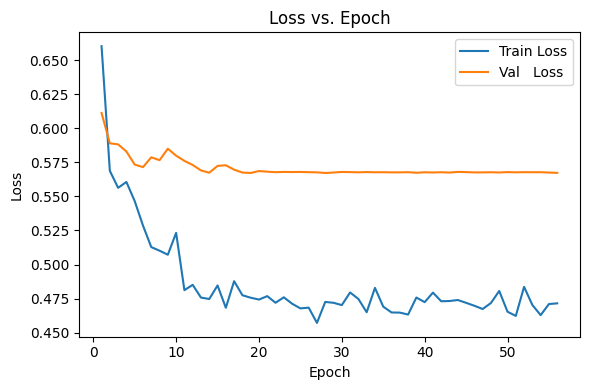

In [14]:
logger.plot()

By running the code above, you have trained your first model!
What do you observe in terms of train and val losses? What is this phenomenon called? (Explain in a few lines below)




This model is very simple and does not necessarilly yield the optimal performance. You are asked to implement your own neural network architecture. You can use convolution networks, vision transformers, etc. Try with different architectures, different model sizes, and other hyper parameters such as learning rate and batch size to find the best performance. Other ideas could be to use augmentation thechniques to boost the performance, adding learning rate schedulers, and exploring other loss functions.

Once you are happy with your model, continue with the rest of the notebook to save your checkpoint and also visualize some plans coming from the model. The last cell will provide a `submission_phase1.csv` which you can submit to the leaderboard to see your results on the testing set.

In [15]:
# save the model
torch.save(model.state_dict(), "phase3_model.pth")

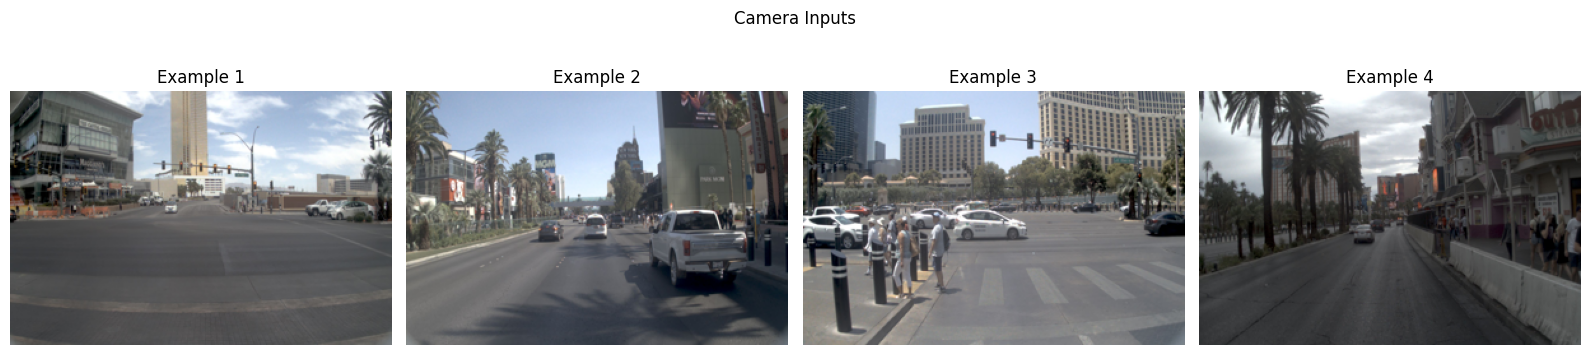

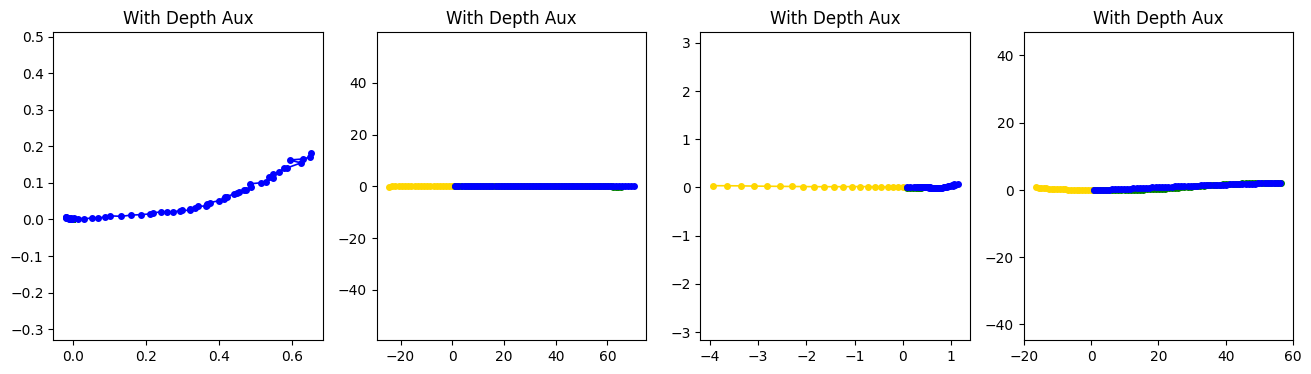

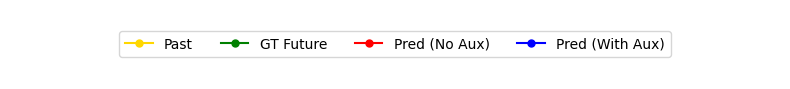

<Figure size 640x480 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt
import random

random.seed(40)

def visualize_comparison(val_loader, model_with_aux, device):
    model_with_aux.eval()
    val_batch = next(iter(val_loader))

    camera = val_batch['camera'].to(device)
    history = val_batch['history'].to(device)
    future = val_batch['future'].to(device)

    with torch.no_grad():
        pred_with_aux, pred_depth, pred_semantic = model_with_aux(camera, history)

    camera = camera.cpu().numpy()
    history = history.cpu().numpy()
    future = future.cpu().numpy()
    pred_with_aux = pred_with_aux.cpu().numpy()
    pred_depth = pred_depth.cpu().numpy() if pred_depth is not None else None
    pred_semantic = pred_semantic.permute(0, 2, 3, 1) if pred_semantic is not None else None
    pred_semantic = pred_semantic.cpu().numpy() if pred_semantic is not None else None
    pred_semantic = np.argmax(pred_semantic, axis=-1) if pred_semantic is not None else None

    k = 4
    indices = random.choices(np.arange(len(camera)), k=k)

    # Show the input camera images
    fig, ax = plt.subplots(1, k, figsize=(4 * k, 4))
    for i, idx in enumerate(indices):
        ax[i].imshow(camera[idx].transpose(1, 2, 0))
        ax[i].set_title(f"Example {i+1}")
        ax[i].axis("off")
    plt.suptitle("Camera Inputs")
    plt.tight_layout()
    plt.show()

    # Compare predicted trajectories
    fig, ax = plt.subplots(1, k, figsize=(4 * k, 4))
    for i, idx in enumerate(indices):
        # With aux
        ax[i].plot(history[idx, :, 0], history[idx, :, 1], 'o-', label='Past', color='gold', markersize=4, linewidth=1.2)
        ax[i].plot(future[idx, :, 0], future[idx, :, 1], 'o-', label='GT Future', color='green', markersize=4, linewidth=1.2)
        ax[i].plot(pred_with_aux[idx, :, 0], pred_with_aux[idx, :, 1], 'o-', label='Pred (With Aux)', color='blue', markersize=4, linewidth=1.2)
        ax[i].set_title("With Depth Aux")
        ax[i].axis("equal")

    # Show full legend in a new figure
    fig_legend = plt.figure(figsize=(8, 1))
    legend_handles = [
        plt.Line2D([0], [0], color='gold', marker='o', linestyle='-', markersize=5, label='Past'),
        plt.Line2D([0], [0], color='green', marker='o', linestyle='-', markersize=5, label='GT Future'),
        plt.Line2D([0], [0], color='red', marker='o', linestyle='-', markersize=5, label='Pred (No Aux)'),
        plt.Line2D([0], [0], color='blue', marker='o', linestyle='-', markersize=5, label='Pred (With Aux)')
    ]
    fig_legend.legend(handles=legend_handles, loc='center', ncol=4)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    plt.suptitle("Trajectory Prediction: Without vs With Depth Aux Task")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# 🔚 Call at the end after training both models
visualize_comparison(val_loader, model, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

Now we run our model on the test set once, to get the plan of our model and save it for submission. Notice that the ground truth plans are removed for the test set, so you can not calculate the ADE metric on the test set yourself, and need to submit it to the leader board. By running the last cell, you'll be able to see a csv file called `submission_phase1.csv` by clicking on the folder icon on the left. Download it and submit it to the leaderboard to get your score.

In [17]:
with open(f"phase3/test_public_real/0.pkl", "rb") as f:
    data = pickle.load(f)
print(data.keys())
# Note the absence of sdc_future_feature

dict_keys(['camera', 'sdc_history_feature'])


In [18]:
import pandas as pd

test_data_dir = "phase3/test_public_real"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_files = [os.path.join(test_data_dir, fn) for fn in sorted([f for f in os.listdir(test_data_dir) if f.endswith(".pkl")], key=lambda fn: int(os.path.splitext(fn)[0]))]
test_dataset = DrivingDataset(test_files, test=True)
test_loader = DataLoader(test_dataset, batch_size=250, num_workers=0)
model.eval()
all_plans = []
with torch.no_grad():
    for batch in test_loader:
        camera = batch['camera'].to(device)
        history = batch['history'].to(device)

        pred_future, _, _ = model(camera, history)
        all_plans.append(pred_future.cpu().numpy()[..., :2])
all_plans = np.concatenate(all_plans, axis=0)

# Now save the plans as a csv file
pred_xy = all_plans[..., :2]  # shape: (total_samples, T, 2)

# Flatten to (total_samples, T*2)
total_samples, T, D = pred_xy.shape
pred_xy_flat = pred_xy.reshape(total_samples, T * D)

# Build a DataFrame with an ID column
ids = np.arange(total_samples)
df_xy = pd.DataFrame(pred_xy_flat)
df_xy.insert(0, "id", ids)

# Column names: id, x_1, y_1, x_2, y_2, ..., x_T, y_T
new_col_names = ["id"]
for t in range(1, T + 1):
    new_col_names.append(f"x_{t}")
    new_col_names.append(f"y_{t}")
df_xy.columns = new_col_names

# Save to CSV
df_xy.to_csv("submission_phase3.csv", index=False)

print(f"Shape of df_xy: {df_xy.shape}")

Shape of df_xy: (864, 121)
